(lecture15:maximum-likelihood-example)=
# Example: Regression with estimated measurement noise

Let's reuse our synthetic dataset:

$$
y_i = -0.5 + 2 x_i + + 2 x_i^2 + 0.1\epsilon_i,
$$

where $\epsilon_i \sim N(0,1)$ and where we sample $x_i \sim U([0,1])$.
Here is how to generate this synthetic dataset and how it looks like:

In [1]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

import numpy as np
import scipy.stats as st

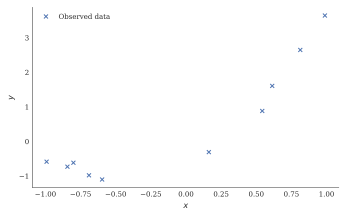

In [2]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = make_full_width_fig()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

We will be fitting polynomials, so let's copy-paste the code we developed for computing the design matrix:

In [3]:
def get_polynomial_design_matrix(x, degree):
    """Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

In the previous section, we saw that when least squares are interpreted probabilistically the weight estimate does not change.
So, we can obtain it just like before:

In [4]:
# The degree of the polynomial
degree = 2
# The design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)
# Solve the least squares problem
w, sum_res, _, _ = np.linalg.lstsq(Phi, y, rcond=None)

Notice that we have now also stored the second output of ``numpy.linalg.lstsq``. This is the sum of the residuals, i.e., it is:

$$
\sum_{i=1}^N\left[y_i - \sum_{j=1}^Mw_j\phi_j(x_i)\right]^2 = \parallel \mathbf{y}_{1:N} - \mathbf{\Phi}\mathbf{w}\parallel_2^2.
$$

Let's test this just to be sure...

In [6]:
print(f'sum_res = {sum_res[0]:1.4f}')
print(f'compare to = {np.linalg.norm(y-np.dot(Phi, w)) ** 2:1.4f}')

sum_res = 0.1646
compare to = 0.1646


It looks correct. We saw that the sum of residuals gives us the maximum likelihood estimate of the noise variance through this formula:

$$
\sigma^2 = \frac{\parallel \mathbf{y}_{1:N} - \mathbf{\Phi}\mathbf{w}\parallel_2^2}{N}.
$$

Let's compute it:

In [7]:
sigma2_MLE = sum_res[0] / num_obs
sigma_MLE = np.sqrt(sigma2_MLE)
print(f'True sigma = {sigma_true:1.4f}')
print(f'MLE sigma = {sigma_MLE:1.4f}')

True sigma = 0.1000
MLE sigma = 0.1283


Let's also visualize this noise.
The prediction at each $x$ is Gaussian with mean $\mathbf{w}^T\boldsymbol{\phi}(x)$ and variance $\sigma_{\text{MLE}}^2$.
So, we can simply create a 95% credible interval by subtracting and adding (about) two $\sigma_{\text{MLE}}$ to the mean.

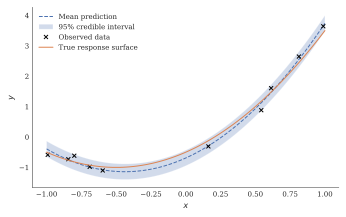

In [8]:
fig, ax = make_full_width_fig()
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# The mean prediction of the model we just fitted
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy = np.dot(Phi_xx, w)
# Lower bound for 95% credible interval
sigma_MLE = np.sqrt(sigma2_MLE)
yy_l = yy - 2.0 * sigma_MLE
# Upper bound for 95% credible interval
yy_u = yy + 2.0 * sigma_MLE
# plot mean prediction
ax.plot(xx, yy, '--', label='Mean prediction')
# plot shaded area for 95% credible interval
ax.fill_between(xx, yy_l, yy_u, alpha=0.25, label='95% credible interval')
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best')
save_for_book(fig, 'ch15.fig21')

## Questions

+ Increase the number of observations ``num_obs`` and notice that the likelihood noise converges to the true measurement noise.
+ Change the polynomial degree to one so that you just fit a line. What does the model think about the noise now?